# Visión por Computador - Práctica 1 - Filtrado de Imágenes

#### 10 puntos   |   Fecha de entrega: 22 de Octubre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2324.ugr.es/

### Estudiante: GONZÁLEZ DURÁN, DAVID





---



## Normas de entrega

Para este trabajo, al igual que para los demás, se debe presentar código, resultados, discusión de los mismos, y presentación y análisis del trabajo realizado, todo integrado en este mismo Google Colab Notebook. Se recuerda que código y resultados sin informe explicativo no puntúa.

Este trabajo de implementación tiene como objetivo principal familiarizarse con la implementación y uso de filtros de convolución, así como del cálculo de las derivadas de una imagen y sus posibles aplicaciones.

El diseño de celdas del documento debe ser respetado.

Solo se entregará el código fuente (fichero .ipynb incorporando código, resultados, y explicación del trabajo realizado y los resultados obtenidos) y no se enviarán las imágenes empleadas.

El path para la lectura de imágenes, o cualquier otro fichero de entrada, debe ser siempre “/content/drive/My Drive/images/nombre_fichero”

El código deberá  presentarse con los resultados obtenidos en cada apartado junto con los  correspondientes comentarios y valoraciones. De nuevo, recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.



---



## Funciones de apoyo y conexión con Google Drive

In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


In [ ]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [ ]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2,maxcolumns=3):
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Ejercicio 1: discretización de máscaras y filtrado Gaussiano** (4 puntos).

En este ejercicio aprenderemos a discretizar máscaras de convolución y a aplicarlas sobre imágenes empleando funciones de OpenCV. También buscamos hacerlo de un modo eficiente, y es por ello que, en toda la práctica, se exige el uso de convoluciones 1D (separables).

El documento pdf sobre Gaussian discretization disponible en PRADO (https://pradogrado2324.ugr.es/pluginfile.php/178298/mod_folder/content/0/Material%20de%20Apoyo/Gaussian_discretization.pdf) puede resultar de gran utilidad para la implementación del primer ejercicio.




## A) (1.5 puntos)

Calcule las máscaras discretas 1D de la Gaussiana y tanto su primera como segunda derivadas (normalizadas). Considere que la entrada a dicha función de creación de máscaras 1D puede ser tanto un posible sigma como un posible tamaño de máscara. Emplee los siguientes valores de sigma ($\{1, 2.5, 5\}$) y los siguientes valores de tamaño de máscara ($\{5, 9, 15\}$), y muestre el perfil (es decir, la silueta de las máscaras como funciones 1D) para verificar que las máscaras creadas son correctas.

Antes de nada, definiremos la función gaussiana unidimensional, así como su primera y segunda derivada:  

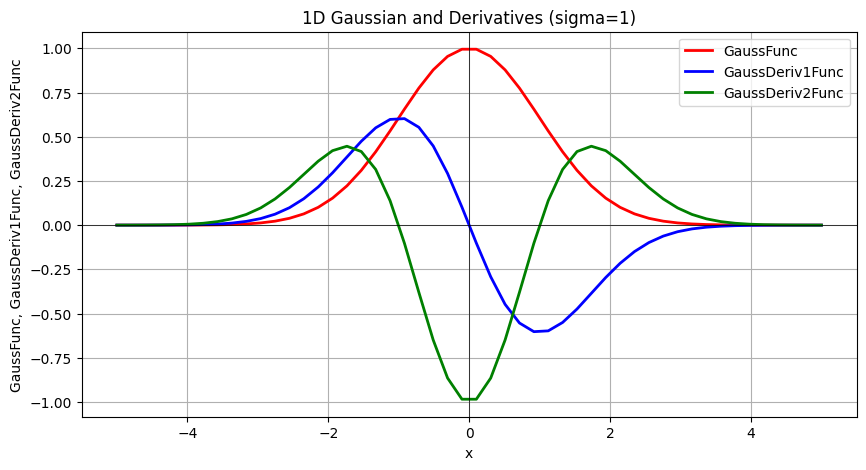

In [ ]:
def GaussFunc(x,sigma):
    return np.exp(-(x**2)/(2*sigma**2))

def GaussDeriv1Func(x,sigma):
    return GaussFunc(x,sigma) * (-x/(sigma**2))

def GaussDeriv2Func(x,sigma):
    return (x ** 2 - sigma ** 2) * GaussFunc(x, sigma) / (sigma ** 4)


# Con la siguiente figura verificamos que las funciones Gaussianas implementadas son correctas
plt.figure(figsize=(10, 5))
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.grid(True)
plt.legend()

Esta que representamos no es exactamente una función de densidad de probabilidad gaussiana, ya que no hemos escalado la curva por la constante necesaria para que el área debajo de ella sea igual a 1. Esto no nos importa, ya que planeamos discretizar más tarde los valores de la distribución normal, lo que nos permitirá lograr la normalización deseada y obtener valores que sumen 1.

Ahora definiremos la función discretizadora de la gaussiana y sus derivadas. Esta función proporcionará los valores enteros en el dominio que se encuentran dentro de tres desviaciones estándar tanto a la izquierda como a la derecha, además de los valores que la distribución toma en cada uno de estos puntos.

La función permitirá definir su dispersión mediante tanto la desviación estándar (sigma) como el tamaño de la máscara:

In [ ]:
def gaussianMask1D(sigma=0, sizeMask=0, order=0):

    # Validar los parámetros de entrada
    if sigma == 0 and sizeMask == 0:
        raise ValueError("Se debe especificar al menos un valor para 'sigma' o 'sizeMask'.")

    if sizeMask != 0:
        if sizeMask % 2 == 0:                                                   # Si el sizeMask especificado no es impar, se aumentará en uno su valor.
          sizeMask += 1
        sigma = (sizeMask - 1) / 6

    elif sigma != 0:
        sizeMask = math.ceil(6 * sigma)
        if sizeMask % 2 == 0:
          sizeMask += 1

    first_value = -math.floor(sizeMask / 2)
    xvalues = np.arange(first_value, first_value + sizeMask)

    # Calcular la máscara gaussiana en función del orden
    if order == 0:
        mask = GaussFunc(xvalues, sigma)
        mask /= sum(mask)                                                       # Con esta línea se logra que la suma de todos los valores sea 1
    elif order == 1:
        mask = GaussDeriv1Func(xvalues, sigma)                                  # Es correcto?
        # mask *= sigma
    elif order == 2:
        mask = GaussDeriv2Func(xvalues, sigma)                                  # Es correcto?
        # mask *= (sigma**2)
    else:
        raise ValueError("El 'order' debe ser 0, 1 o 2 para la derivada de orden.")

    return mask, xvalues

He tratado de calcular el tamaño de la máscara de una manera diferente a la descrita en las transparencias, pues creo que es más precisa a la hora de incluir el mínimo número de pixeles posible que garantice que se contienen todos los píxeles dentro de un rango de tres desviaciones estándar en ambas direcciones.
$$
T = \left\{
\begin{array}{rcl}
\lceil 6 · \sigma \rceil      & \mbox{si}  & \lceil 6 · \sigma \rceil \mod 2 = 0\\
\lceil 6 · \sigma + 1 \rceil  & \mbox{si}  & \lceil 6 · \sigma \rceil \mod 2 = 1\\
\end{array}
\right.
$$

Una vez con el tamaño de máscara y la desviación típica, se obtienen los valores del dominio en los que se definirá la función de densidad discritizada, todos alrededor de 0, obviamente. Luego, obtenemos los valores de la imagen que corresponden a la función normal continua —o a alguna de sus derivadas— en los puntos enteros del dominio.

En caso de la gaussiana sin derivar, habrá que normalizar los valores obtenidos para que sumen 1, esto se hace dividiendo cada valor entre la suma del conjunto de valores.

En caso de las derivadas de la gaussiana, no es necesario realizar ninguna operación adicional, pues por defecto los valores calculados sumarán todos 0.

Ahora comprobememos cómo queda la gaussiana discretizada con los valores sigma y tamaño de máscara solicitados:

FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA


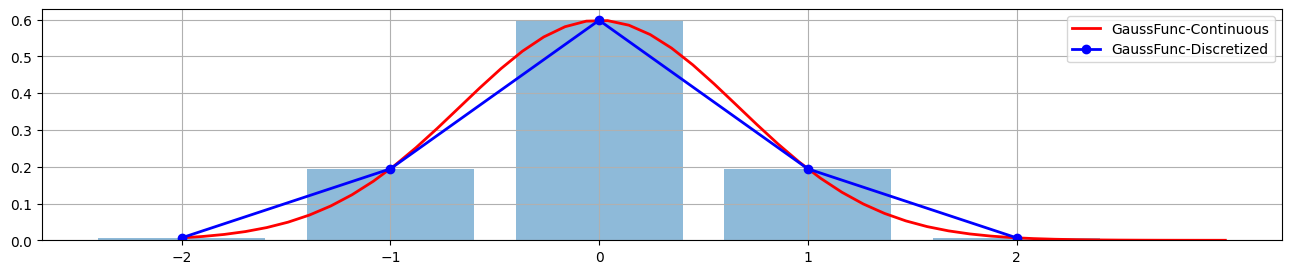

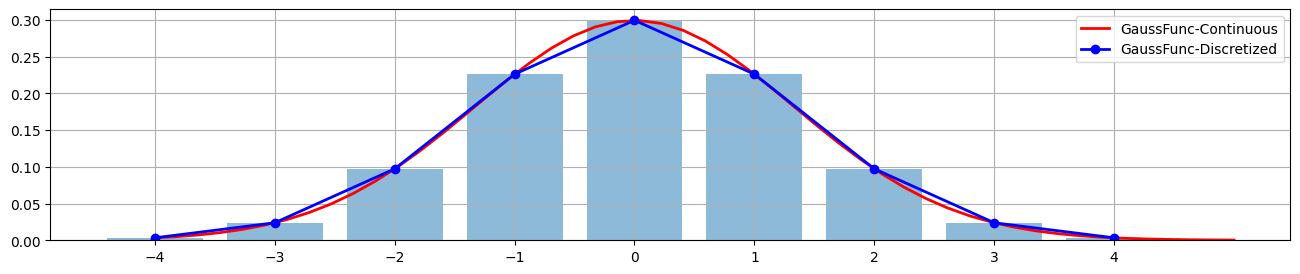

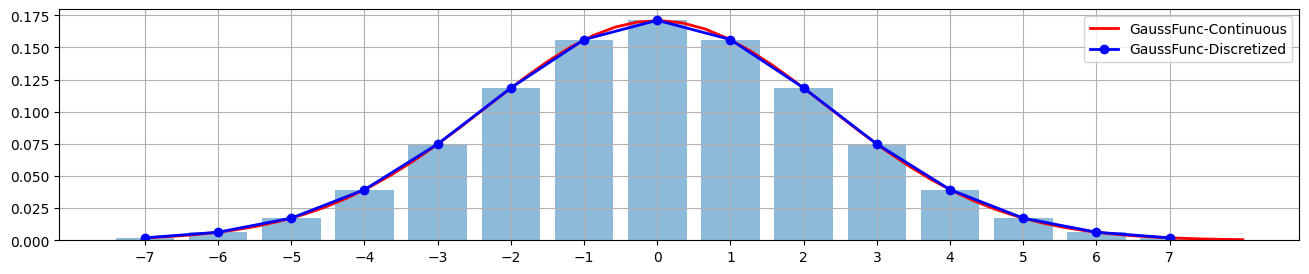

FIJAMOS AHORA EL SIGMA


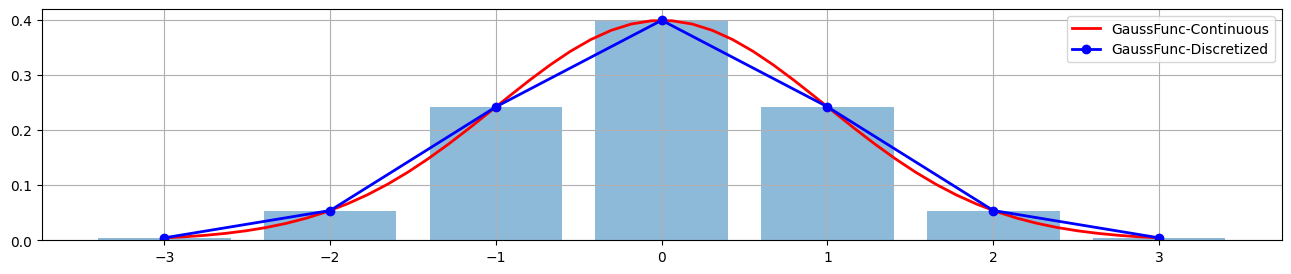

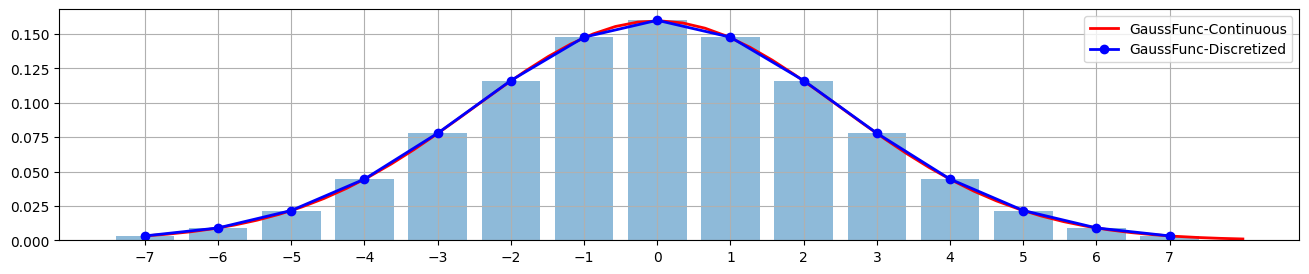

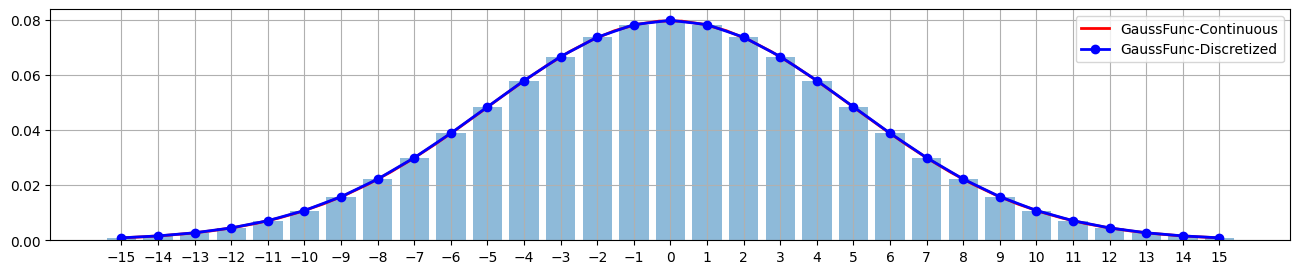

In [ ]:
size_masks = [5,9,15]
sigma_values = [1, 2.5, 5]

# Ajuste de tamaño de la figura a (ancho, alto)
plt.rcParams["figure.figsize"] = (16,3)

print('FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA')
for sizeMask in size_masks:

    # Graficar la distribución normal continua
    xvaluesc = np.linspace(-math.floor(sizeMask/2), -math.floor(sizeMask/2)+sizeMask)
    sigma = (sizeMask-1)/6
    yvalues1 = GaussFunc(xvaluesc,sigma) * 1/(sigma*math.sqrt(2*math.pi))
    plt.plot(xvaluesc, yvalues1, lw=2, color='red', label='GaussFunc-Continuous')

    # Obtener los valores de x de la máscara gaussiana discretizada para el tamaño de máscara requerido
    mask, xvalues = gaussianMask1D(sizeMask=sizeMask, order=0)
    # Graficar la máscara gaussiana
    plt.plot(xvalues, mask, marker="o", lw=2, color='blue', label='GaussFunc-Discretized')
    # Agregar histograma
    plt.bar(xvalues, mask, width=0.8, alpha=0.5)


    plt.legend()
    # Agregar cuadrícula (líneas horizontales y verticales)
    plt.grid(True)
    # Establecer las marcas en el eje x
    plt.xticks(np.arange(min(xvalues), max(xvalues)+1, step=1))
    # Mostrar gráfica
    plt.show()


print('FIJAMOS AHORA EL SIGMA')
for sigma in sigma_values:

    # Graficar la distribución normal continua
    sizeMask = math.ceil(6 * sigma)
    xvaluesc = np.linspace(-math.floor(sizeMask/2), -math.floor(sizeMask/2)+sizeMask)
    yvalues1 = GaussFunc(xvaluesc,sigma) * 1/(sigma*math.sqrt(2*math.pi))
    plt.plot(xvaluesc, yvalues1, lw=2, color='red', label='GaussFunc-Continuous')

    # Obtener los valores de x de la máscara gaussiana discretizada para el sigma actual
    mask, xvalues = gaussianMask1D(sigma=sigma, order=0)
    # Graficar la máscara gaussiana
    plt.plot(xvalues, mask, marker="o", lw=2, color='blue', label='GaussFunc-Discretized')
    # Agregar histograma
    plt.bar(xvalues, mask, width=0.8, alpha=0.5)


    plt.legend()
    # Agregar cuadrícula (líneas horizontales y verticales)
    plt.grid(True)
    # Establecer las marcas en el eje x
    plt.xticks(np.arange(min(xvalues), max(xvalues)+1, step=1))
    # Mostrar la gráfica
    plt.show()

AHORA COMPROBEMOS CON LA PRIMERA DERIVADA


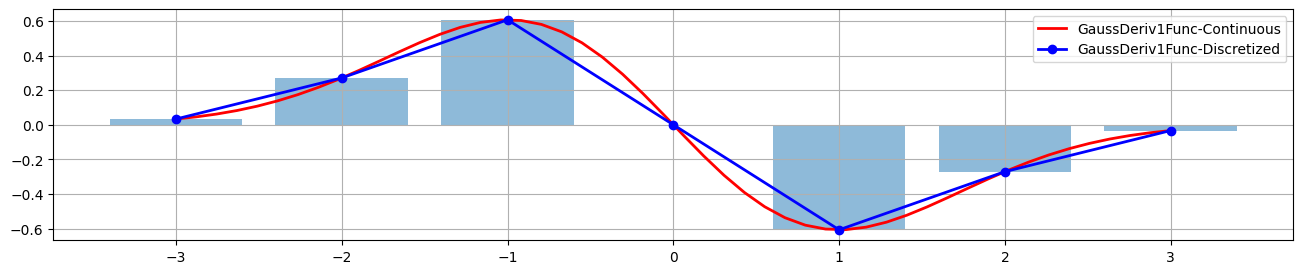

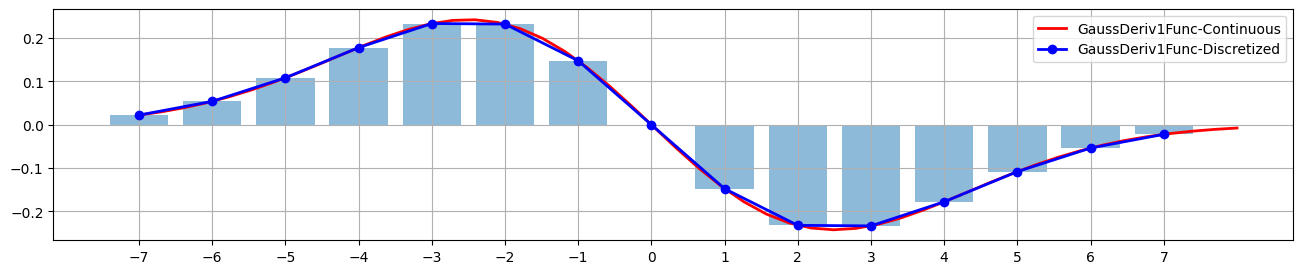

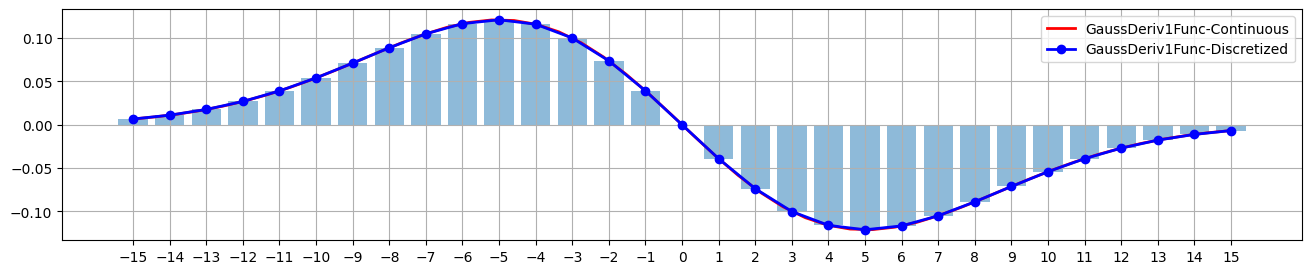

In [ ]:
sigma_values = [1, 2.5, 5]

print('AHORA COMPROBEMOS CON LA PRIMERA DERIVADA')
for sigma in sigma_values:

    # Graficar la primera derivada de la distribución normal continua
    sizeMask = math.ceil(6 * sigma)
    xvaluesc = np.linspace(-math.floor(sizeMask/2), -math.floor(sizeMask/2)+sizeMask)
    yvalues1 = GaussDeriv1Func(xvaluesc,sigma) #* 1/(sigma*math.sqrt(2*math.pi))
    plt.plot(xvaluesc, yvalues1, lw=2, color='red', label='GaussDeriv1Func-Continuous')

    # Obtener los valores de x de la máscara gaussiana discretizada para el sigma actual
    mask, xvalues = gaussianMask1D(sigma=sigma, order=1)
    # Graficar la máscara gaussiana
    plt.plot(xvalues, mask, marker="o", lw=2, color='blue', label='GaussDeriv1Func-Discretized')
    # Agregar histograma
    plt.bar(xvalues, mask, width=0.8, alpha=0.5)

    plt.legend()
    # Agregar cuadrícula (líneas horizontales y verticales)
    plt.grid(True)
    # Establecer las marcas en el eje x
    plt.xticks(np.arange(min(xvalues), max(xvalues)+1, step=1))
    # Mostrar la gráfica
    plt.show()

AHORA COMPROBEMOS CON LA SEGUNDA DERIVADA


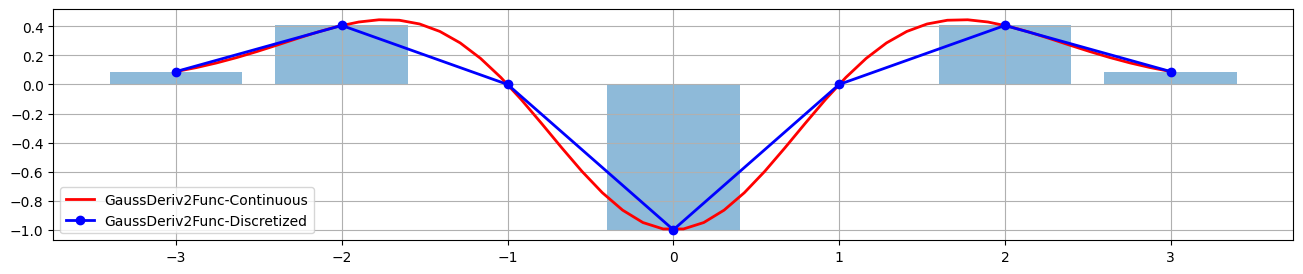

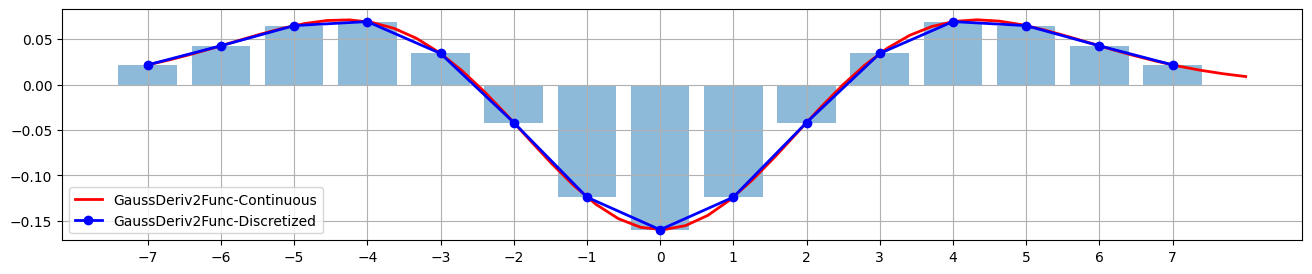

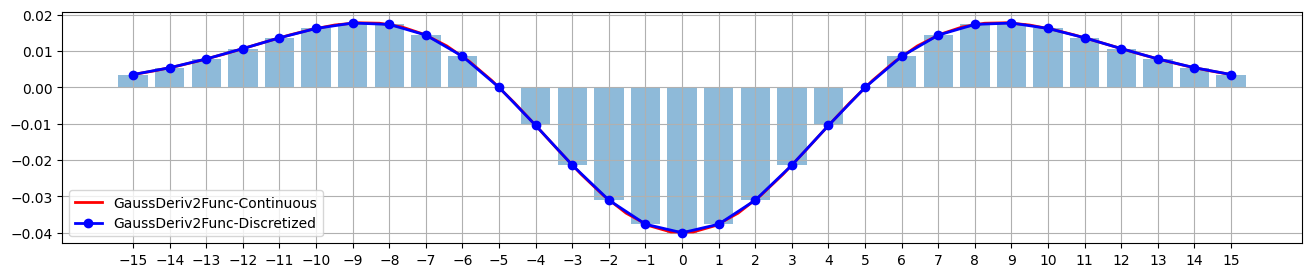

In [ ]:
sigma_values = [1, 2.5, 5]

print('AHORA COMPROBEMOS CON LA SEGUNDA DERIVADA')
for sigma in sigma_values:

    # Graficar la segunda derivada de la distribución normal  continua
    sizeMask = math.ceil(6 * sigma)
    xvaluesc = np.linspace(-math.floor(sizeMask/2), -math.floor(sizeMask/2)+sizeMask)
    yvalues1 = GaussDeriv2Func(xvaluesc,sigma)
    plt.plot(xvaluesc, yvalues1, lw=2, color='red', label='GaussDeriv2Func-Continuous')

    # Obtener los valores de x de la máscara gaussiana discretizada para el sigma actual
    mask, xvalues = gaussianMask1D(sigma=sigma, order=2)
    # Graficar la máscara gaussiana
    plt.plot(xvalues, mask, marker="o", lw=2, color='blue', label='GaussDeriv2Func-Discretized')
    # Agregar histograma
    plt.bar(xvalues, mask, width=0.8, alpha=0.5)

    plt.legend()
    # Agregar cuadrícula (líneas horizontales y verticales)
    plt.grid(True)
    # Establecer las marcas en el eje x
    plt.xticks(np.arange(min(xvalues), max(xvalues)+1, step=1))
    # Mostrar la gráfica
    plt.show()

Como podemos apreciar, tanto la gaussiana como sus derivadas discretizadas se asemejan significativamente a sus versiones continuas, especialmente cuando se incrementa la desviación típica o, en otros palabras, el tamaño de la máscara.

## B) (1.5 puntos)

Lea una imagen en escala de grises y fíltrela mostrando el resultado de la convolución con una Gaussiana, con la primera derivada de la Gaussiana (tanto en X como en Y), y con la segunda derivada de la Gaussiana (tanto en X como en Y). Emplee los siguientes sigmas: $\{0.75,2,5,10,15\}$. Muestra todas las imágenes dentro del mismo canvas, tal y como se muestra más abajo. En este apartado, se debe usar la función de OpenCV `sepFilter2D()` con las máscaras calculadas con las funciones desarrolladas en el apartado anterior.




En este ejercicio se nos pide una aplicación de la separabilidad de los filtros gaussianos. Obtendremos varias imágenes:
1. **Aplicando UN FILTRO GAUSSIANO SIN DERIVAR EN AMBAS DIRECCIONES**: De esta forma, la **imagen se suavizará**, al promediar los valores de una región en cada pixel de la imagen. Como resultado, se reducirán las altas frecuencias en la imagen, ya que las transiciones abruptas se volverán menos notables al ser atenuadas por el promedio. Por esto este tipo de filtro se denomina **filtro paso bajo**, dado que permite el paso de las frecuencias bajas mientras atenúa las frecuencias altas.
2. **Aplicando UN FILTRO GAUSSIANO DERIVADO EN UNA DIRECCIÓN Y UNO SIN DERIVAR EN LA OTRA**: La primera derivada gaussiana nos permite visualizar los bordes de la imagen en una dirección, es decir, las regiones en las que hay cambios significativos en la intensidad de los píxeles.
3. **Aplicando UN FILTRO GAUSSIANO DE SEGUNDA DERIVADA EN UNA DIRECCIÓN Y UNO SIN DERIVAR EN LA OTRA**: Al igual que el de la primera, este filtro nos permite detectar bordes, de otra forma.


Es importante resaltar que siempre que se deriva en una dirección se suaviza en la otra. Esto se realiza para reducir el ruido obtenido al derivar, que podría dificultar la detección de bordes.

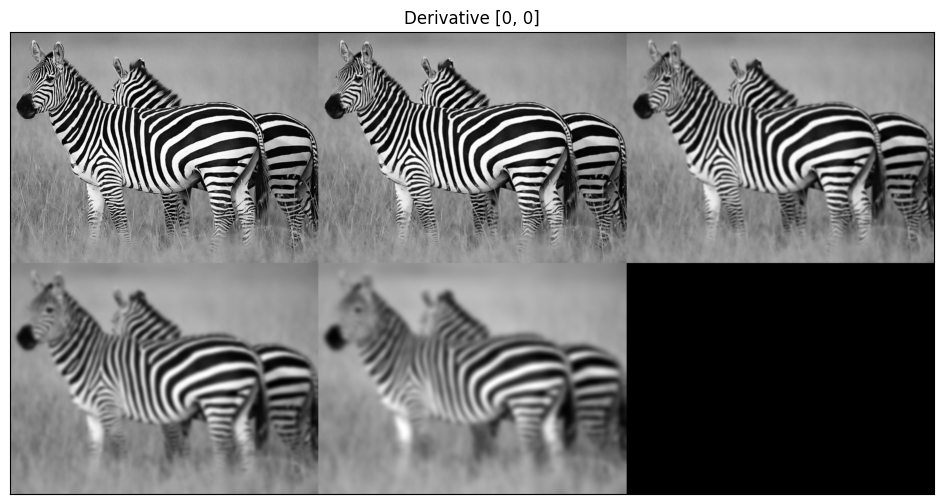

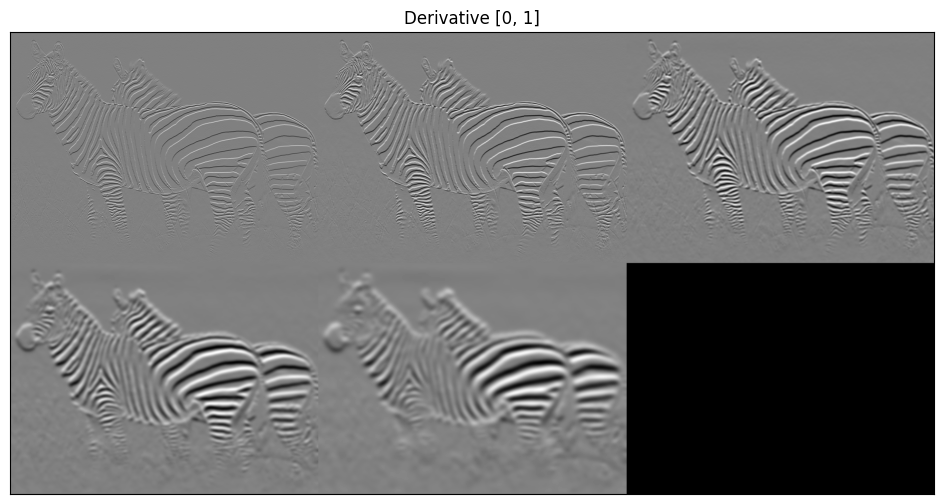

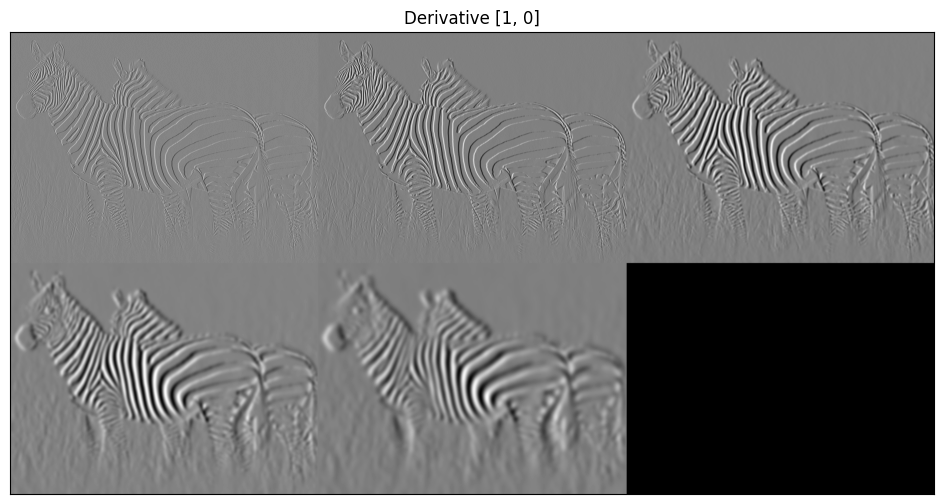

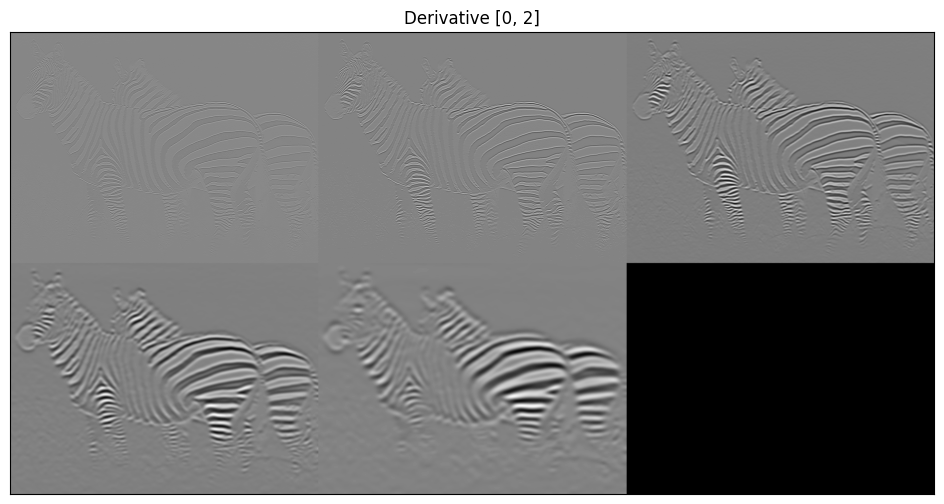

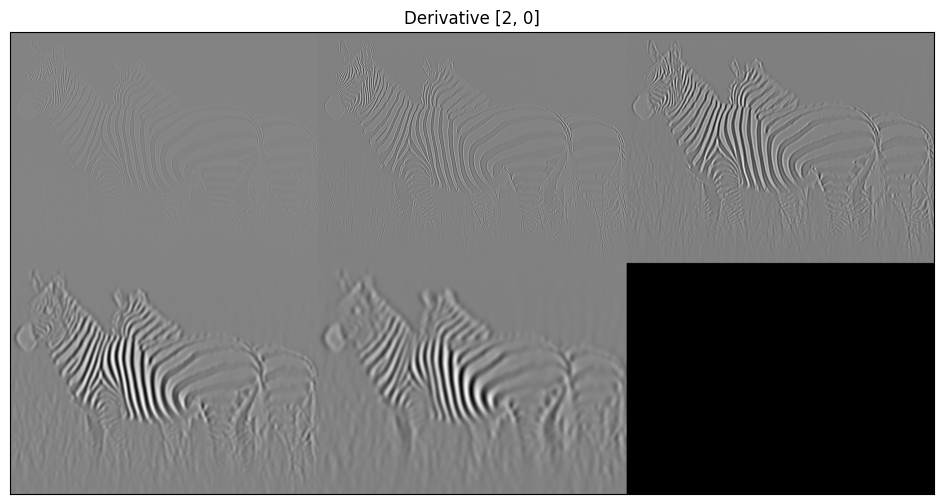

In [ ]:
def my2DConv(im, orders, sigma=0, sizeMask=0):

  ddepth=cv2.CV_64F
  maskG,_ = gaussianMask1D(sigma, sizeMask, order=0)
  maskDG,_ = gaussianMask1D(sigma, sizeMask, order=1)
  mask2DG,_ = gaussianMask1D(sigma, sizeMask, order=2)

  if orders==[0,0]: # Suavizado Gaussiano
    return cv2.sepFilter2D(im, ddepth, maskG, maskG)
  elif orders==[1,0]: # Primera derivada en x
    return cv2.sepFilter2D(im, ddepth, maskDG, maskG)
  elif orders==[0,1]: # Primera derivada en y
    return cv2.sepFilter2D(im, ddepth, maskG, maskDG)
  elif orders==[2,0]: # Segunda derivada en x
    return cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
  elif orders==[0,2]: # Segunda derivada en y
    return cv2.sepFilter2D(im, ddepth, maskG, mask2DG)
  else:
    print('error in order of derivative')


# let's check the function
im=cv2.imread(get_image('zebra.jpg'),0)

for order in [[0,0], [0,1], [1,0], [0,2], [2,0]]:
  vim=[]
  for sigma in [0.75, 2, 5, 10, 15]:
    vim.append(rangeDisplay01(my2DConv(im,order,sigma),True))
    # vim_cv2.append(cv2.GaussianBlur(im,[0,0],sigma))
  displayMI_ES(vim, "Derivative {}".format(order), 2)




## bis\)

Como indicábamos antes, el ruido de una imagen complica la detección del bordes, pues el ruido introduce variaciones aleatorias en la intensidad de los píxeles que no están relacionadas con los bordes reales de los objetos en la imagen. Esto puede causar que se detecten bordes falsos. Veamos un ejemplo visual:

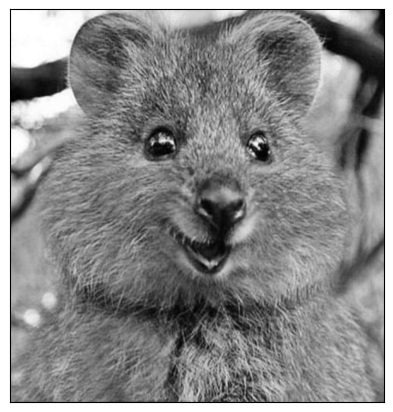

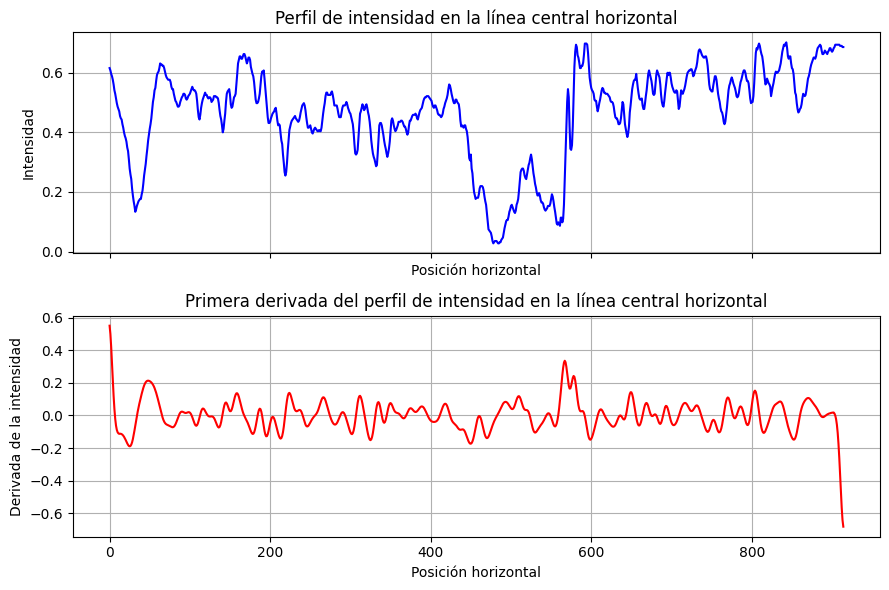

In [ ]:
# Cargamos la imagen en escala de grises y la mostramos
im=cv2.imread(get_image('quokka_original.jpg'),0)
displayIm(rangeDisplay01(im),'',1.7)

# Obtén la línea central horizontal
centro_horizontal = im.shape[0] // 2

# Extrae la fila central horizontal de la imagen y la normaliza entre 0 y 1
linea_central = im[centro_horizontal, :] / 255

# Crea un array de píxeles desde 0 hasta el ancho de la imagen
x = np.arange(im.shape[1])

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 6))

# Crea un gráfico de las intensidades de los píxeles
ax1.plot(x, linea_central, color='b')
ax1.set_title('Perfil de intensidad en la línea central horizontal')
ax1.set_xlabel('Posición horizontal')
ax1.set_ylabel('Intensidad')
ax1.grid(True)

# Calcular la derivada de la línea central
mask1D,_ = gaussianMask1D(sigma=4, order=1)
derivada_linea_central = np.convolve(linea_central, mask1D, 'same')

# derivada_linea_central = np.gradient(linea_central)
ax2.plot(x, derivada_linea_central, color = 'r')
ax2.set_title('Primera derivada del perfil de intensidad en la línea central horizontal')
ax2.set_xlabel('Posición horizontal')
ax2.set_ylabel('Derivada de la intensidad')
ax2.grid(True)

plt.tight_layout()
plt.show()

Son apreciables las altas frecuencias de la derivada del perfil de intensidad. Veamos qué ocurre si suavizamos la imagen:

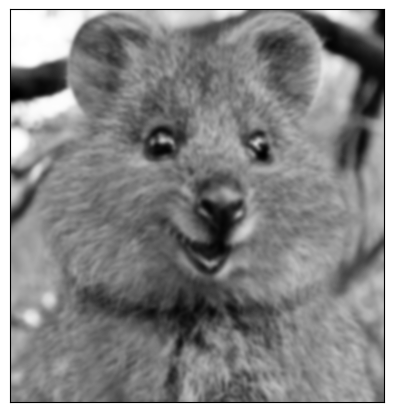

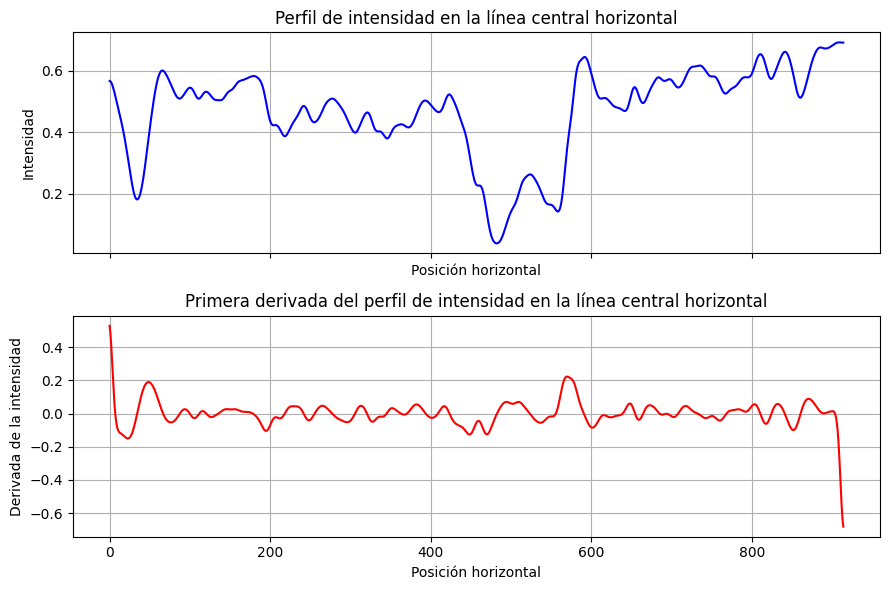

In [ ]:
# Suavizamos la imagen y la mostramos
blurred_im = my2DConv(im,[0,0],sigma=4)

displayIm(rangeDisplay01(blurred_im),'',1.7)

# Obtén la línea central horizontal
centro_horizontal = blurred_im.shape[0] // 2

# Extrae la fila central horizontal de la imagen
linea_central = blurred_im[centro_horizontal, :] / 255

# Crea un array de píxeles desde 0 hasta el ancho de la imagen
x = np.arange(blurred_im.shape[1])

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 6))

# Crea un gráfico de las intensidades de los píxeles
ax1.plot(x, linea_central, color='b')
ax1.set_title('Perfil de intensidad en la línea central horizontal')
ax1.set_xlabel('Posición horizontal')
ax1.set_ylabel('Intensidad')
ax1.grid(True)

# Calcular la derivada de la línea central
mask1D,_ = gaussianMask1D(sigma=4, order=1)
derivada_linea_central = np.convolve(linea_central, mask1D, 'same')

# derivada_linea_central = np.gradient(linea_central)
ax2.plot(x, derivada_linea_central, color = 'r')
ax2.set_title('Primera derivada del perfil de intensidad en la línea central horizontal')
ax2.set_xlabel('Posición horizontal')
ax2.set_ylabel('Derivada de la intensidad')
ax2.grid(True)

plt.tight_layout()
plt.show()


En este caso, con la imagen suavizada, son más apreciables los bordes reales de la imagen.

## C) (1 punto)

Emplee la función de OpenCV `sepFilter2D()` y $\sigma=3.0$ para calcular el gradiente (4 imágenes: derivada en X, derivada en Y, magnitud y orientación) y la Laplaciana de la Gaussiana.

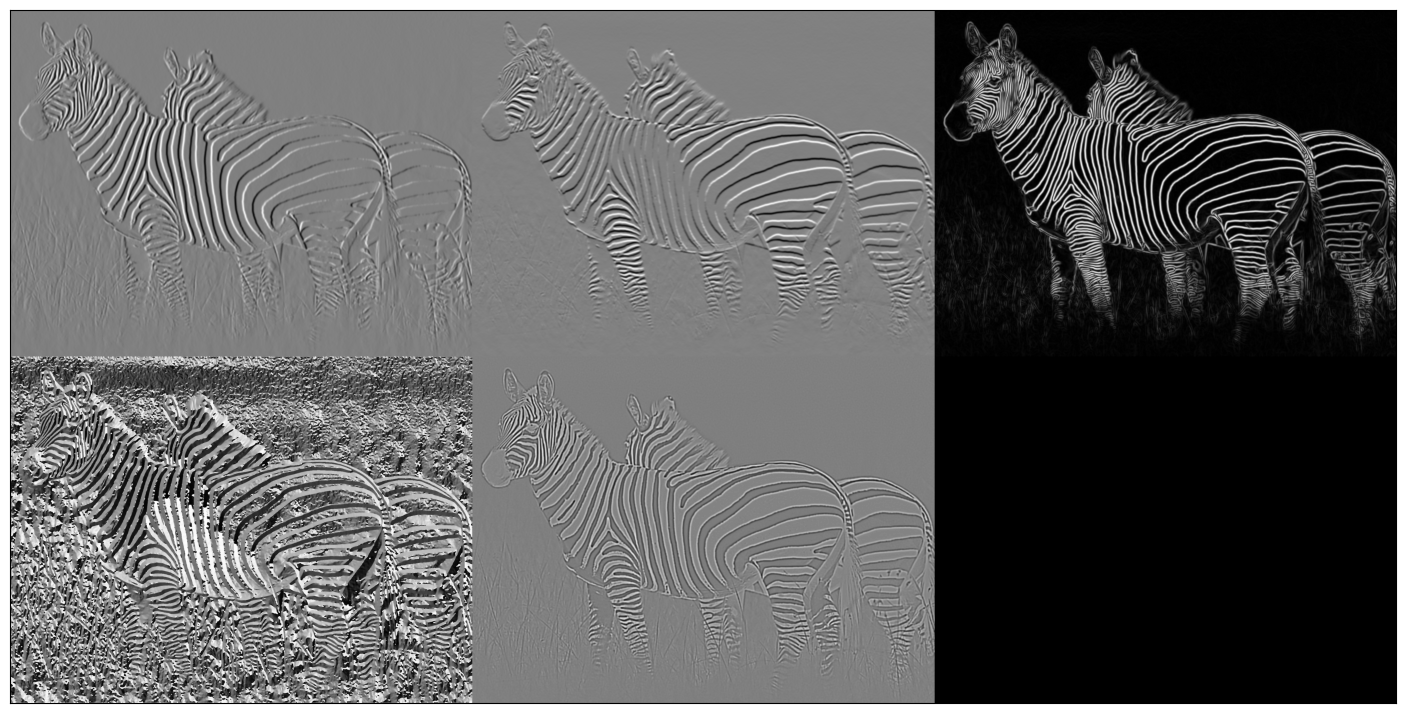

In [ ]:
im=cv2.imread(get_image('zebra.jpg'),0)

sigma = 3
vim=[]

# Derivada horizontal
vim.append(rangeDisplay01( my2DConv(im,[1,0],sigma), True))
# Derivada vertical
vim.append(rangeDisplay01( my2DConv(im,[0,1],sigma), True))
# Magnitud del gradiente
vim.append(rangeDisplay01( np.sqrt(my2DConv(im,[1,0],sigma)**2 + my2DConv(im,[0,1],sigma)**2), True))
# Orientación del gradiente
vim.append(rangeDisplay01( np.arctan2(my2DConv(im,[0,1],sigma), my2DConv(im,[1,0],sigma)), True))
# Laplaciana
vim.append(rangeDisplay01( (my2DConv(im,[0,2],sigma) + my2DConv(im,[2,0],sigma)) * (sigma **2), True))
# Mostrar
displayMI_ES(vim, "", 3)


1. En la **derivada en X**, podemos apreciar tanto líneas blancas, que evidencian cuando un pixel blanco tiene uno negro a su derecha, como líneas negras, que señalan la existencia de un pixel negro junto a uno blanco a su derecha.
2. En la **derivada en Y**, tenemos exactamente lo mismo pero en el sentido vertical. Se aprecian líneas blancas en lugares donde los píxeles blancos tienen un píxel negro directamente debajo, así como líneas negras donde los píxeles negros tienen un píxel blanco justo debajo.
3. La **magnitud del gradiente** nos permite ver resaltados todos los bordes o cambios abruptos de intensidad en la imagen, los que se dan en cualquier dirección.
4. La **orientación del gradiente** es el menos intuitivo de todos los resultados. Indica la dirección en la que cambia la intensidad de la imagen en un punto específico. Ahora mismo no tiene ningún uso especial, pero hay aplicaciones, como el algoritmo de Canny, donde se emplea.
5. La **laplaciana**, según se defiende en la referencia facilitada en la práctica, es más bien un detector de líneas que de bordes; mientras la magnitud del gradiente detecta los dos bordes a lo largo de una línea, la laplaciana detecta la línea en sí, lo que puede ser útil para ciertas aplicaciones.

# **Ejercicio 2**:  Pirámides Gaussianas y Laplacianas (3 points)







## A) (1.5 puntos)

Construya una pirámide Gaussiana de 4 niveles empleando máscaras Gaussianas de tamaño 7x7. No se permite emplear las funciones `pyrUp()` y `pyrDown()` de OpenCV.

En el campo de la visión por computador, muchas veces se necesita visualizar una misma imagen en múltiples escalas, para detectar objetos de diferente tamaño, por ello son tan importantes las pirámides.

La pirámide gaussiana es una serie de imágenes, desde la original a otras versiones cada más suavizadas y submuestradas. El suavizado hace que cada pixel incluya información de su vecindario, reduciendo el efecto de aliasing en el submuestreado.

In [ ]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Piramide de Manzanas')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

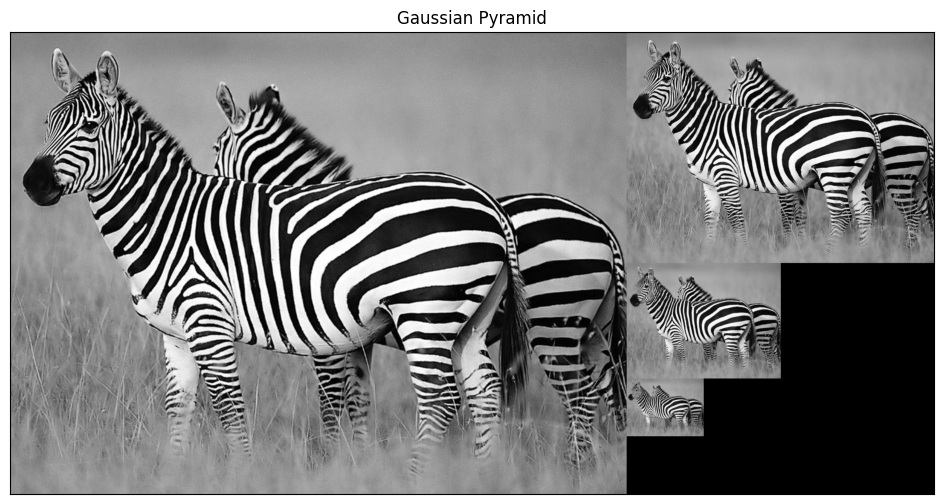

In [ ]:
def pyramidGauss(im, sizeMask=7, nlevel=4):
  vim=[im]

  for i in range(1, nlevel):
    # Aplicar suavizado gaussiano a la imagen del nivel previo
    blurred = my2DConv(vim[i-1],[0,0],sizeMask=sizeMask)

    # Reducir la resolución de la imagen suavizada
    downsampled = cv2.resize(blurred, (blurred.shape[1]//2, blurred.shape[0]//2), interpolation=cv2.INTER_LINEAR)

    # Añade la imagen obtenenida a la pirámide
    vim.append(downsampled)

  return vim

im=cv2.imread(get_image('zebra.jpg'),0)
pyrG = pyramidGauss(im, sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')


## B) (1 punto)

Use su código del apartado anterior para implementar una función que permita construir una pirámide Laplaciana de 4 niveles.

La pirámide Laplaciana es la contraparte de la pirámide gaussiana, pues mientras la pirámide gaussiana suaviza la imagen, eliminando altas frecuencias, y eliminando así detalles de la imagen, la laplaciana conservará las altas frecuencias de la imagen (los detalles).

En realidad, no calcularemos directamente la Laplaciana de la imagen, sino que estamos calculando la diferencia de gaussianas como una aproximación de la misma.

La pirámide laplaciana se nutrirá de los elementos de una pirámide gaussiana para calcular los suyos. En concreto, un elemento de la laplaciana se calcula como la diferencia entre el elemento en la misma posición de la gaussiana y la expandida de la misma imagen suavizada. Esto quiere decir, la imagen extrae de si misma las frecuencias bajas, obtenidas anteriormente de su propia versión suavizada.

Añadiremos el último elemento de la pirámide gaussiana a la pirámide laplaciana, de esta forma, podremos reconstruir la imagen, como veremos a continuación.

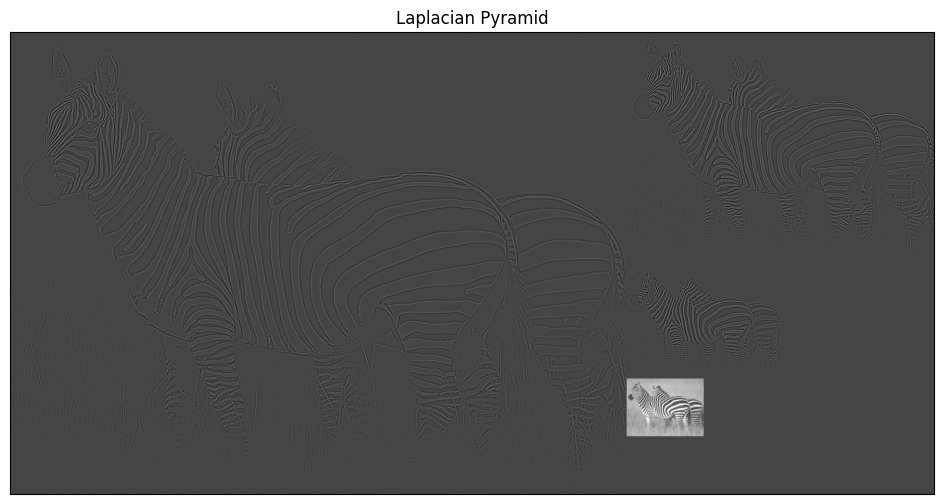

In [ ]:
def pyramidLap(im,sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR):
  vim=pyrG=pyramidGauss(im,sizeMask=sizeMask, nlevel=nlevel)
  vimL=[]

  vimL.append(vim[-1])

  for i in range(nlevel - 1, 0, -1): # i toma los valores de nlevel-1 hasta 0

    # Ampliar la resolución de la imagen
    upsampled = cv2.resize(vim[i], (vim[i-1].shape[1], vim[i-1].shape[0]), interpolation=flagInterp)

    # Calcular la laplaciana restando la imagen ampliada de la imagen gaussiana original
    laplacian = vim[i-1] - upsampled

    # Añade la imagen obtenenida a la pirámide
    vimL.append(laplacian)

  vimL = vimL[::-1]

  return vimL

im=cv2.imread(get_image('zebra.jpg'),0)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid')

Como podemos apreciar, los elementos de la laplaciana (o, más bien, diferencia de gaussianas) solo marcan detalles, como son en este caso las rayas de la cebra.

## C) (0.5 puntos)

Implemente ahora una función para reconstruir la imagen codificada en la pirámide Laplaciana. Verifique que es posible obtener una copia exacta de la imagen original. Para ello, calcule el error de reconstrucción como la norma Euclídea de las diferencias entre los niveles de intensidad de la imagen original y la imagen reconstruida.

Una imagen se puede reconstruir a partir de su **pirámide laplaciana**, ya que esta pirámide **retiene toda la información de la imagen original**. El **último nivel de la pirámide conserva las bajas frecuencias de la imagen** original, mientras que los **niveles anteriores contienen las frecuencias más altas**.

Este proceso de reconstrucción comienza con el último elemento de la pirámide, que es la versión de imagen más suavizada y submuestrada. Se expande esta imagen utilizando una técnica de interpolación lineal, como la interpolación bilineal. Tras esto, se agrega la intensidad del siguiente último elemento de la laplaciana, añadiendo así detalles a la imagen. Repitiendo este proceso hasta emplear todos los elementos de la pirámide, se logra una reconstrucción fiel de la imagen original.

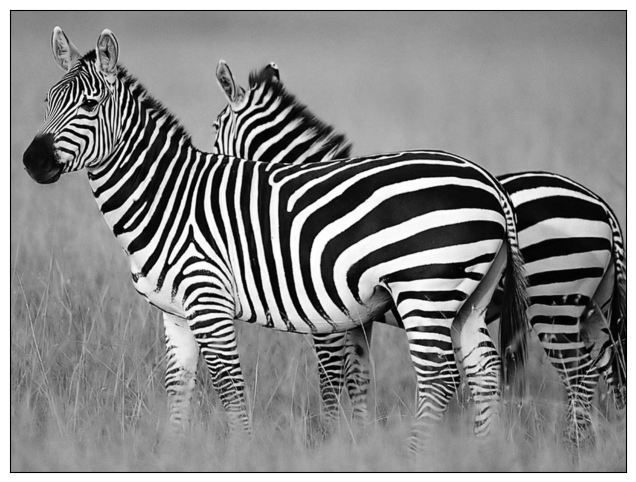

Error per pixel 0.0


In [ ]:
def reconstructLap(pyL,flagInterp=cv2.INTER_LINEAR):

  im=pyL[-1]

  for i in range(len(pyL)-2, -1, -1):

    # Ampliar la resolución de la imagen
    upsampled = cv2.resize(im, (pyL[i].shape[1], pyL[i].shape[0]), interpolation=flagInterp)

    # Calcular la imagen original sumando a la imagen gaussiana la laplaciana del tamaño correspondiente
    im = upsampled + pyL[i]

  return im


recons = reconstructLap(pyrL)
displayIm(recons,'',2)
print('Error per pixel',np.sqrt(np.linalg.norm(im-np.round(recons), ord=2)/np.prod(im.shape)))

# **Ejercicio 3: Imágenes Híbridas** (2 puntos)

Este ejercicio se basa en el siguiente trabajo: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$. (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

El objetivo es aprender cómo el sistema visual humano extrae información sobre un objeto en función de la distancia. Para ello, construimos una imagen híbrida a partir de dos imágenes de objetos diferentes. Mezclando adecuadamente parte de las altas frecuencias de una imagen con parte de las bajas frecuencias de otra imagen, obtenemos una imagen híbrida que muestra diferentes percepciones con la distancia. El sigma empleado para filtrar ambas imágenes (tanto la de alta como la de bajas frecuencias) es el aspecto clave para seleccionar el rango de frecuencias altas y bajas de cada imagen. Cuanto mayor sea el valor sigma, mayor será la eliminación de altas frecuencias de la imagen. Se recomienda elegir este valor por separado para cada una de las imágenes y, de hecho, seguramente sea posible (y deseable) el tener distintos valores para distintos pares de imágenes. Recuerde emplear la pirámide Gaussiana para mostrar el efecto obtenido.

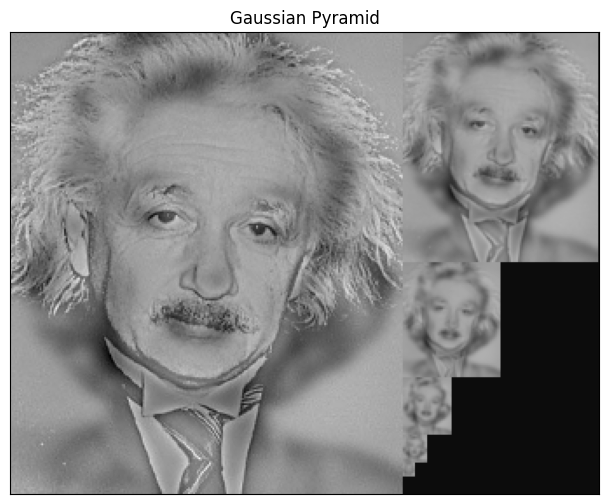

In [ ]:
im1=cv2.imread(get_image('marilyn.bmp'),0)  # Imagen con aspecto más suavizado (bajas frecuencias)
im2=cv2.imread(get_image('einstein.bmp'),0) # Imagen con bordes más acentuados (altas frecuencias)

def hibridarImagen(im1, im2, sigma1, sigma2):

  # Suavizado de imagen 1 (amplifica bajas frecuencias)
  im1 = my2DConv(im1,[0,0],sigma1)

  # Acentuado de imagen 2 (amplifica altas frecuencias)
  im2 = (im2 - my2DConv(im2,[0,0],sigma2))

  return (im1 + im2)/2


im = hibridarImagen(im1, im2, sigma1=4, sigma2=3)
pyrG = pyramidGauss(im, sizeMask=7, nlevel=6)
displayPyramid(pyrG,'Gaussian Pyramid')

Las frecuencias altas de una imagen son dominantes en distancias cercanas, mientras que las frecuencias bajas prevalecen en distancias largas, es por esto que destacará la figura de Einstein vista de cerca, y, por contrario, será la de Marilyn la que destaque vista a mayor distancia.

La pirámide gaussiana nos permite percibir ambas figuras sin necesidad de acercarnos o alejarnos, pues al suavizar y submuestrear una imagen se logra el mismo efecto visual de alejarnos de ella, es por esto que a medida que se obtienen imágenes de la pirámide gaussiana, se destacan las frecuencias bajas, y es más apreciable el rostro de Marilyn.

## Creación de imágenes auxiliares

Crearé unas imágenes que utilizaré como máscaras para el siguiente ejercicio.

In [ ]:
image = np.zeros((256, 256, 3), dtype=np.uint8)
half_width = image.shape[1] // 2
image[:, half_width:] = (255, 255, 255)
cv2.imwrite('/content/drive/My Drive/images/mask_vertical.jpg', image)

start_col = image.shape[1] // 2 - 8  # 8 píxeles a la izquierda del centro
end_col = image.shape[1] // 2 + 8   # 8 píxeles a la derecha del centro
image[:, start_col:end_col] = (127, 127, 127)
cv2.imwrite('/content/drive/My Drive/images/mask_con_franja_gris.jpg', image)

image = np.zeros((256, 256, 3), dtype=np.uint8)
half_width = image.shape[0] // 2
image[half_width:, :] = (255, 255, 255)
cv2.imwrite('/content/drive/My Drive/images/mask_horizontal.jpg', image)

True

# **Ejercicio 4: Pyramid Blending** (1 punto)

En este ejercicio se debe crear la imagen fusionada (horizontal) de la manzana (`apple.jpg`) y la naranja (`orange.jpg`) empleando la técnica de $\textit{Pyramid Blending}$. Para este ejercicio, si se desea, sí se pueden emplear las funciones de OpenCV `pyrDown` y `pyrUp`. Para que el ejercicio puntúe, es esencial explicar en detalle el proceso seguido a la hora de crear la nueva imagen (mezcla de ambas). El resultado debe ser similar al mostrado en la celda de resultados correspondiente.  



In [ ]:
def resize_max_dimensions(*images):
  # Obtener las dimensiones máximas entre todas las imágenes
  max_rows = max(img.shape[1] for img in images)
  max_cols = max(img.shape[0] for img in images)

  # Cambiar la resolución de cada imagen
  resized_images = [cv2.resize(img, (max_cols, max_rows)) for img in images]

  return tuple(resized_images)

La pirámide gaussiana de la máscara difuminará cada vez más el borde del centro, creando una franja vertical con valores grises de mayor y menor intensidad, que permitirá combinar altas y bajas frecuencias de las imágenes de manera

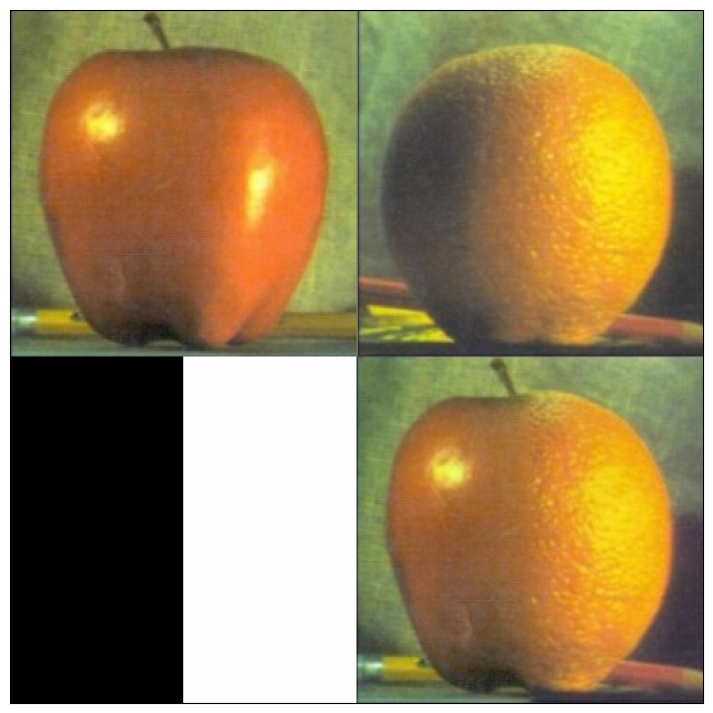

In [ ]:
def pyramideBlend(im1, im2, mask, nlevel=4):

  lp_im1 = pyramidLap(im1,sizeMask=5, nlevel=nlevel)
  lp_im2 = pyramidLap(im2,sizeMask=5, nlevel=nlevel)
  gauss_mask = pyramidGauss(mask/255, sizeMask=11, nlevel=nlevel)

  lp_im = [(1-gauss_mask[i]) * lp_im1[i] + gauss_mask[i] * lp_im2[i]
            for i in range(0, nlevel)]

  return reconstructLap(lp_im)


im1 = readIm(get_image('apple.jpg'),1)
im2 = readIm(get_image('orange.jpg'),1)
mask1 = readIm(get_image('mask_vertical.jpg'),1)

im1, im2, mask1 = resize_max_dimensions(im1, im2, mask1)

result1 = pyramideBlend(im1, im2, mask1, nlevel=8)
displayMI_ES([im1, im2, mask1, result1], '', 3, maxcolumns=2)

Ahora vamos a probar a mezclar las imágenes con otras máscaras similares:
1. La primera máscara, con una banda vertical gris en el centro. La intención de emplear esta es poder comprobar si mejora la mezcla al incluir esta banda gris, que deja mezclar más gaussianas y laplacianas de ambas imágenes contenidas en su región.
2. La segunda máscara, tal como la máscara vertical estándar, pero en horizontal.  

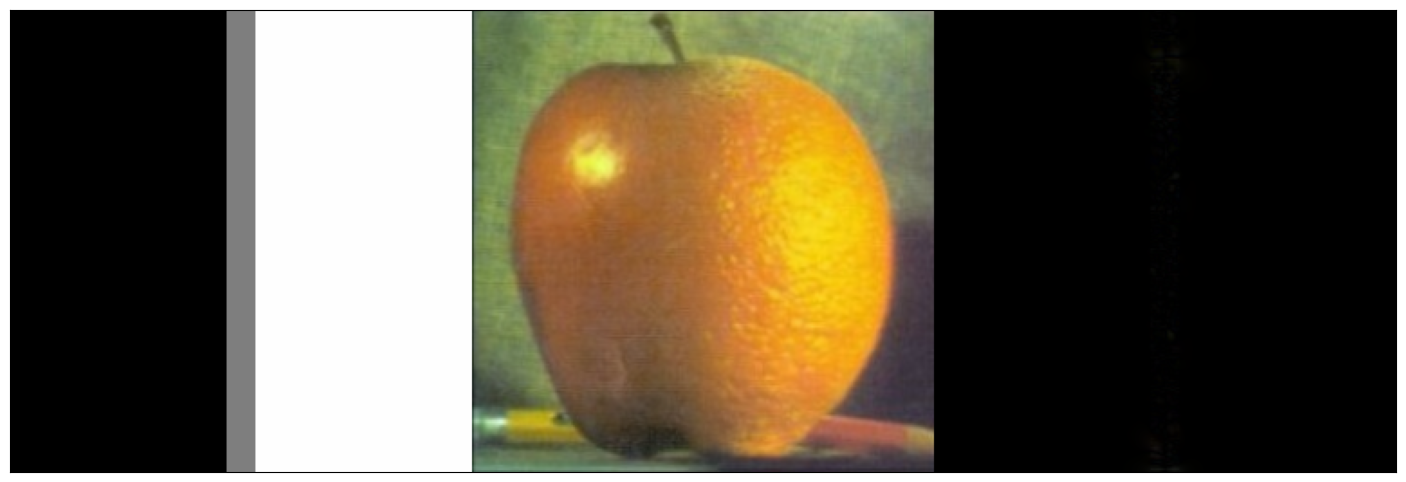

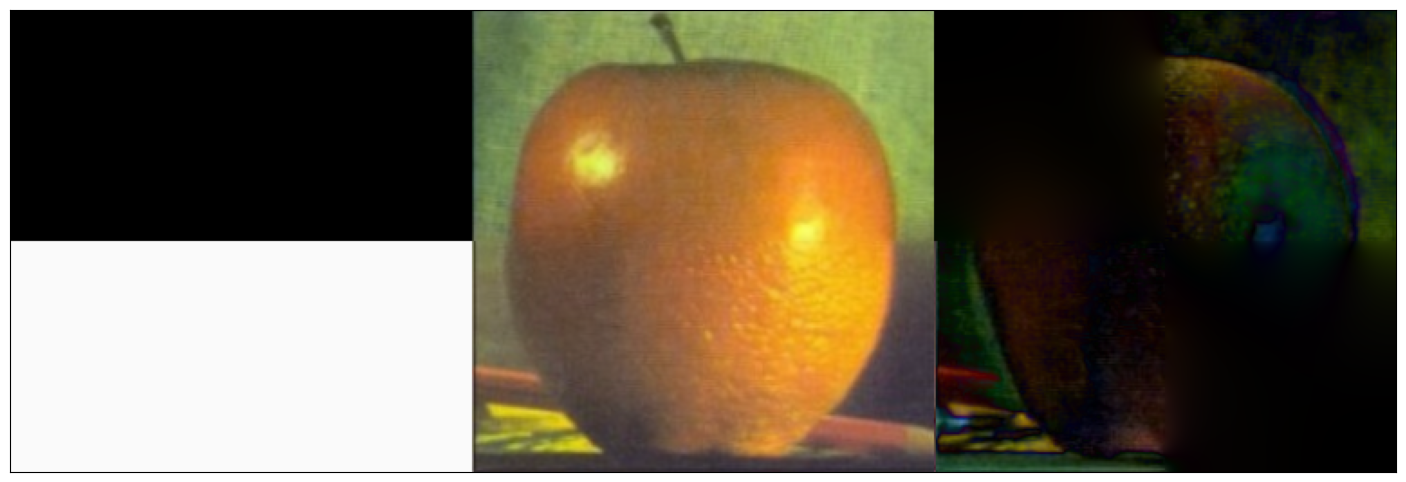

In [ ]:
mask2 = readIm(get_image('mask_con_franja_gris.jpg'),1)
mask3 = readIm(get_image('mask_horizontal.jpg'),1)

im1, im2, mask2, mask3 = resize_max_dimensions(im1, im2, mask2, mask3)

result2 = pyramideBlend(im1, im2, mask2, nlevel=8)
result3 = pyramideBlend(im1, im2, mask3, nlevel=8)

displayMI_ES([mask2, result2, np.absolute(result2-result1)], '', 2)
displayMI_ES([mask3, result3, np.absolute(result3-result1)], '', 2)

Podemos apreciar que la imagen obtenida del aplicado de filtro con franja gris no varía mucho de la filtrada con la máscara vertical, de hecho, a la derecha se ve la diferencia en términos absolutos, y está prácticamente vacía. Esto probablemente se deba a que los borden de la manzana y la naranja no varían mucho de posición, veamos un ejemplo con otra imagen:

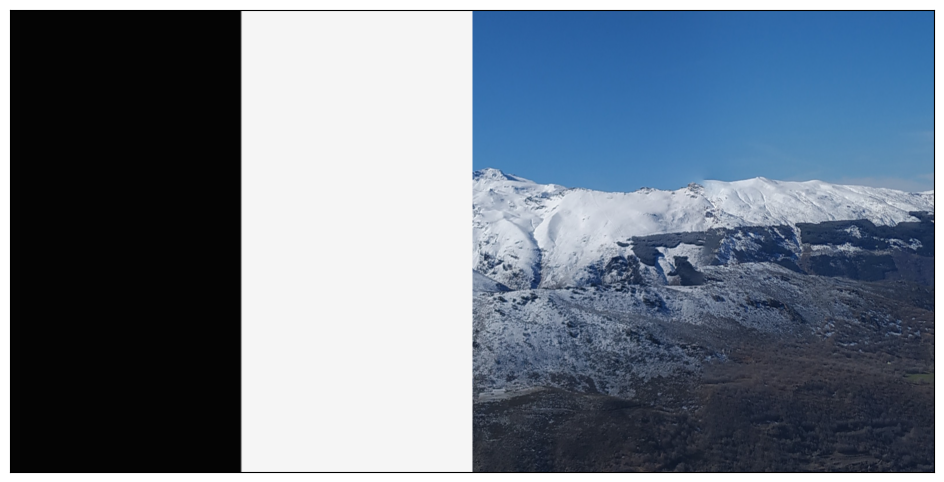

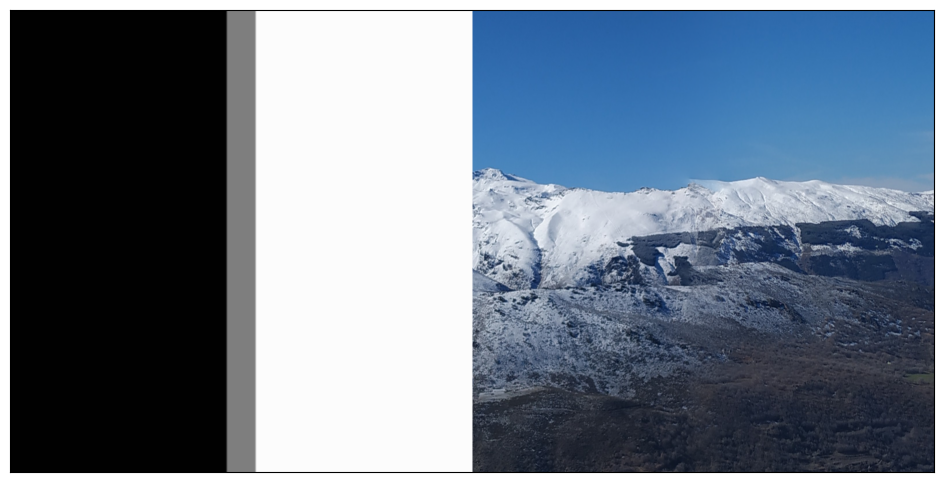

In [ ]:
im1 = readIm(get_image('IMG_20220312_102957_S.jpg'),1)
im2 = readIm(get_image('IMG_20220312_102958_S.jpg'),1)

im1, im2, mask1, mask2, mask3 = resize_max_dimensions(im1, im2, mask1, mask2, mask3)

result1 = pyramideBlend(im1, im2, mask1, nlevel=8)
result2 = pyramideBlend(im1, im2, mask2, nlevel=8)

displayMI_ES([mask1, result1], '', 2)
displayMI_ES([mask2, result2], '', 2)

En este ejemplo, en cambio, sí es apreciable una diferencia, y es que usando de filtro la imagen con franja gris se logran unos "bordes fantasma" que se superponen en la imagen.
La gracia del pyramide blending es que se van añadiendo las altas frecuencias de manura gradual en la frontera suavizada de la imagen

El pyramide blending logra un efecto suave y natural al incorporar gradualmente —gracias al suavizado gaussiano— las frecuencias de alta resolución en la región de transición de la imagen.